In [1]:
import cv2, zarr, json, gc
import matplotlib.pyplot as plt, numpy as np, pandas as pd
from pathlib import Path
gc.enable()

from tqdm.notebook import tqdm
import rasterio

In [2]:
from config.global_vars import TILE_SHAPE

### Settings

In [3]:
TEST_PATH = Path('/home/jupyter/data_2/test')
assert TEST_PATH.exists()
g_out = zarr.group(f'/home/jupyter/test/anatomy')

In [4]:
identity = rasterio.Affine(1, 0, 0, 0, 1, 0)

In [5]:
for i, filename in tqdm(enumerate(TEST_PATH.glob('*.tiff')), total = len(list(TEST_PATH.glob('*.tiff')))):
    idx = filename.stem
    anatomical_structure = Path(f'{str(filename.parent)}/{idx}-anatomical-structure.json')
    assert anatomical_structure.exists()
    with open(anatomical_structure) as json_file:
        data = json.load(json_file)
    dataset = rasterio.open(filename.as_posix(), transform = identity)
    dataset_shape = dataset.shape
    umat = cv2.UMat(np.zeros((dataset_shape[0], dataset_shape[1]), dtype=np.uint8))
    
    # Fill array
    for poly in data:
        coords = poly['geometry']['coordinates']
        value = 1 if poly['properties']['classification']['name'] == 'Cortex' else 2
        coords_cand = [coords] if len(coords) == 1 else coords
        for coord in coords_cand:
            coords2 = cv2.UMat(np.array([(int(a), int(b)) for a, b in coord[0]]))
            umat = cv2.fillConvexPoly(umat, coords2, value)
            
    g_out[idx] = umat.get()

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.6/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


  0%|          | 0/5 [00:00<?, ?it/s]

2ec3f1bb9


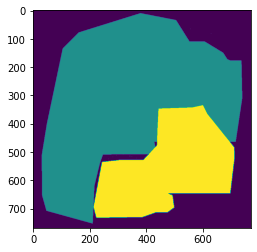

3589adb90


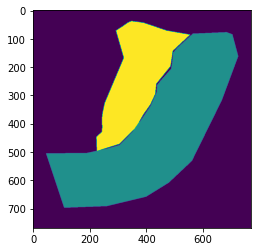

57512b7f1


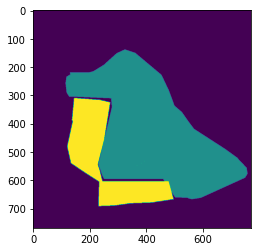

aa05346ff


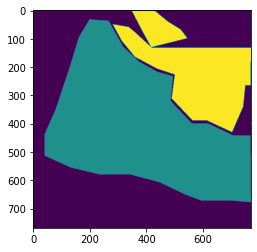

d488c759a


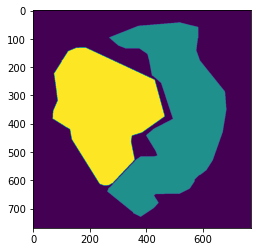

In [6]:
for i, filename in tqdm(enumerate(TEST_PATH.glob('*.tiff')), total = len(list(TEST_PATH.glob('*.tiff')))):
    idx = filename.stem
    print(idx)
    plt.imshow(cv2.resize(g_out[idx][:], dsize=(TILE_SHAPE, TILE_SHAPE)))
    plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

2ec3f1bb9
3589adb90
57512b7f1
aa05346ff
d488c759a


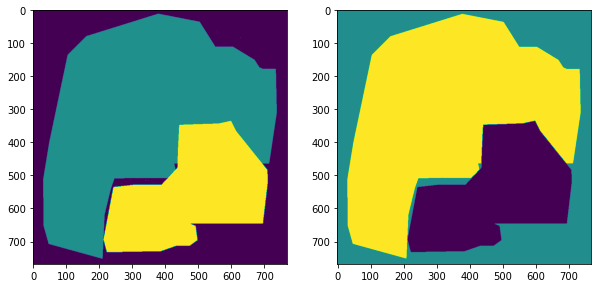

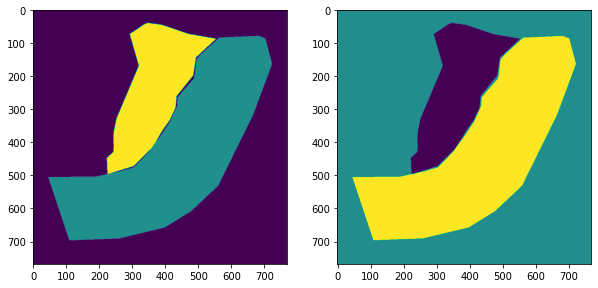

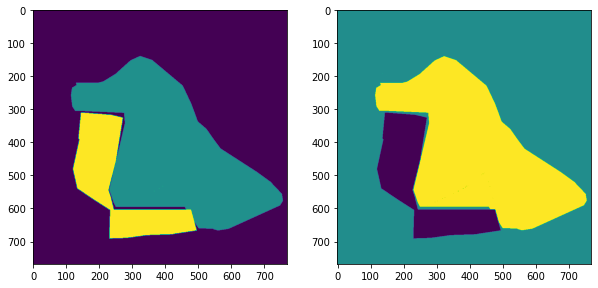

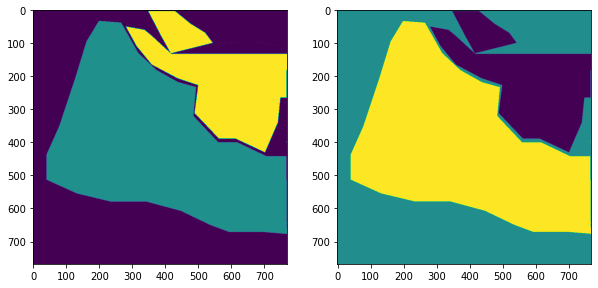

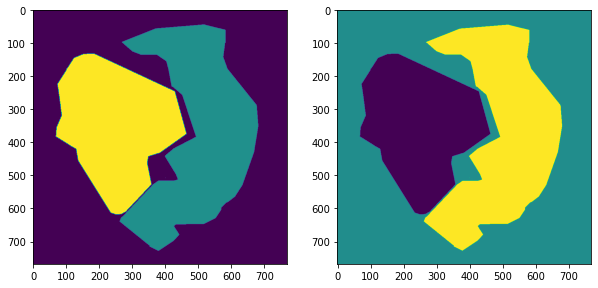

In [11]:
for i, filename in tqdm(enumerate(TEST_PATH.glob('*.tiff')), total = len(list(TEST_PATH.glob('*.tiff')))):
    idx = filename.stem
    print(idx)
    mask = g_out[idx][:]
    weight_mask = np.where(mask == 0, 0.75, mask).astype(np.float32)
    weight_mask = np.where(weight_mask == 2, 0.51, weight_mask).astype(np.float32)
    fig, ax = plt.subplots(ncols=2, figsize=(10,10))
    ax[0].imshow(cv2.resize(mask, dsize=(TILE_SHAPE, TILE_SHAPE)))
    ax[1].imshow(cv2.resize(weight_mask, dsize=(TILE_SHAPE, TILE_SHAPE)))

In [9]:
np.unique(weight_mask, return_counts=True)

(array([0.51, 0.75, 1.  ], dtype=float32),
 array([270778840, 746883384, 336410976]))

In [12]:
weight_mask

array([[0.75, 0.75, 0.75, ..., 0.75, 0.75, 0.75],
       [0.75, 0.75, 0.75, ..., 0.75, 0.75, 0.75],
       [0.75, 0.75, 0.75, ..., 0.75, 0.75, 0.75],
       ...,
       [0.75, 0.75, 0.75, ..., 0.75, 0.75, 0.75],
       [0.75, 0.75, 0.75, ..., 0.75, 0.75, 0.75],
       [0.75, 0.75, 0.75, ..., 0.75, 0.75, 0.75]], dtype=float32)

In [13]:
746883384 - 336410976

410472408